## NN Implementation
Adapted from https://github.com/fpingham/DeepSteg/blob/master/DeepSteganography.ipynb

In [1]:
# Imports necessary libraries and modules
from itertools import islice
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
from torch import utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os 
import pickle
from torchvision import datasets, utils
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from random import shuffle
from IPython.display import Image

In [2]:
# Directory path
#cwd = 'input'

# Hyper Parameters
num_epochs = 3
batch_size = 2
learning_rate = 0.0001
beta = 1

# Mean and std deviation of imagenet dataset. Source: http://cs231n.stanford.edu/reports/2017/pdfs/101.pdf
#std = [0.229, 0.224, 0.225]
#mean = [0.485, 0.456, 0.406]

# TODO: Define train, validation and models
MODELS_PATH = 'models'
# TRAIN_PATH = cwd+'/train/'
# VALID_PATH = cwd+'/valid/'
TRAIN_PATH = 'coast/train/'
TEST_PATH = 'coast/test/'

#if not os.path.exists(MODELS_PATH): os.mkdir(MODELS_PATH)

In [13]:
def customized_loss(S_prime, C_prime, S, C, B):
    ''' Calculates loss specified on the paper.'''
    
    loss_cover = torch.nn.functional.mse_loss(C_prime, C)
    loss_secret = torch.nn.functional.mse_loss(S_prime, S)
    loss_all = loss_cover + B * loss_secret
    return loss_all, loss_cover, loss_secret

def denormalize(image, std, mean):
    ''' Denormalizes a tensor of images.'''

    for t in range(3):
        image[t, :, :] = (image[t, :, :] * std[t]) + mean[t]
    return image

def imshow(img, idx, learning_rate, beta):
    '''Prints out an image given in tensor format.'''
    
    #img = denormalize(img, std, mean)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Example '+str(idx)+', lr='+str(learning_rate)+', B='+str(beta))
    plt.show()
    return

def gaussian(tensor, mean=0, stddev=0.1):
    '''Adds random noise to a tensor.'''
    
    noise = torch.nn.init.normal(torch.Tensor(tensor.size()), 0, 0.1)
    return Variable(tensor + noise)

In [4]:
# Preparation Network (2 conv layers)
class PrepNetwork(nn.Module):
    def __init__(self):
        super(PrepNetwork, self).__init__()
        self.initialP3 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialP4 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialP5 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalP3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalP4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalP5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())

    def forward(self, p):
        p1 = self.initialP3(p)
        p2 = self.initialP4(p)
        p3 = self.initialP5(p)
        mid = torch.cat((p1, p2, p3), 1)
        p4 = self.finalP3(mid)
        p5 = self.finalP4(mid)
        p6 = self.finalP5(mid)
        out = torch.cat((p4, p5, p6), 1)
        return out

# Hiding Network (5 conv layers)
class HidingNetwork(nn.Module):
    def __init__(self):
        super(HidingNetwork, self).__init__()
        self.initialH3 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialH4 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialH5 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalH3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalH4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalH5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalH = nn.Sequential(
            nn.Conv2d(150, 3, kernel_size=1, padding=0))
        
    def forward(self, h):
        h1 = self.initialH3(h)
        h2 = self.initialH4(h)
        h3 = self.initialH5(h)
        mid = torch.cat((h1, h2, h3), 1)
        h4 = self.finalH3(mid)
        h5 = self.finalH4(mid)
        h6 = self.finalH5(mid)
        mid2 = torch.cat((h4, h5, h6), 1)
        out = self.finalH(mid2)
        out_noise = gaussian(out.data, 0, 0.1)
        return out, out_noise

# Reveal Network (2 conv layers)
class RevealNetwork(nn.Module):
    def __init__(self):
        super(RevealNetwork, self).__init__()
        self.initialR3 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialR4 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialR5 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalR3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalR4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalR5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalR = nn.Sequential(
            nn.Conv2d(150, 3, kernel_size=1, padding=0))

    def forward(self, r):
        r1 = self.initialR3(r)
        r2 = self.initialR4(r)
        r3 = self.initialR5(r)
        mid = torch.cat((r1, r2, r3), 1)
        r4 = self.finalR3(mid)
        r5 = self.finalR4(mid)
        r6 = self.finalR5(mid)
        mid2 = torch.cat((r4, r5, r6), 1)
        out = self.finalR(mid2)
        return out

# Join three networks in one module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.m1 = PrepNetwork()
        self.m2 = HidingNetwork()
        self.m3 = RevealNetwork()

    def forward(self, secret, cover):
        x_1 = self.m1(secret)
        mid = torch.cat((x_1, cover), 1)
        x_2, x_2_noise = self.m2(mid)
        x_3 = self.m3(x_2_noise)
        return x_2, x_3

In [5]:
net = Net()

In [6]:
train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
        TRAIN_PATH,
        transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize(mean=mean,
        #std=std)
        ])), batch_size=batch_size, num_workers=1, 
        pin_memory=True, shuffle=True, drop_last=True)

# Creates test set
test_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
        TEST_PATH, 
        transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize(mean=mean,
        #std=std)
        ])), batch_size=2, num_workers=1, 
        pin_memory=True, shuffle=True, drop_last=True)

C:\Users\Andrew Ramirez\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [7]:
def train_model(train_loader, beta, learning_rate):
    
    # Save optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    loss_history = []
    # Iterate over batches performing forward and backward passes
    for epoch in range(num_epochs):

        # Train mode
        net.train()
        
        train_losses = []
        # Train one epoch
        for idx, train_batch in enumerate(train_loader):

            data, _  = train_batch

            # Saves secret images and secret covers
            train_covers = data[:len(data)//2]
            train_secrets = data[len(data)//2:]
            
            # Creates variable from secret and cover images
            train_secrets = Variable(train_secrets, requires_grad=False)
            train_covers = Variable(train_covers, requires_grad=False)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            train_hidden, train_output = net(train_secrets, train_covers)

            # Calculate loss and perform backprop
            train_loss, train_loss_cover, train_loss_secret = customized_loss(train_output, train_hidden, train_secrets, train_covers, beta)
            train_loss.backward()
            optimizer.step()
            
            # Saves training loss
            train_losses.append(train_loss.data)
            loss_history.append(train_loss.data)
            
            # Prints mini-batch losses
            print('Training: Batch {0}/{1}. Loss of {2:.4f}, cover loss of {3:.4f}, secret loss of {4:.4f}'.format(idx+1, len(train_loader), train_loss.data, train_loss_cover.data, train_loss_secret.data))
    
        torch.save(net.state_dict(), MODELS_PATH+'Epoch N{}.pkl'.format(epoch+1))
        
        mean_train_loss = np.mean(train_losses)
    
        # Prints epoch average loss
        print ('Epoch [{0}/{1}], Average_loss: {2:.4f}'.format(
                epoch+1, num_epochs, mean_train_loss))
    
    return net, mean_train_loss, loss_history

In [8]:
net, mean_train_loss, loss_history = train_model(train_loader, beta, learning_rate)

C:\Users\Andrew Ramirez\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Training: Batch 1/144. Loss of 0.5323, cover loss of 0.1401, secret loss of 0.3922
Training: Batch 2/144. Loss of 0.3927, cover loss of 0.1615, secret loss of 0.2311
Training: Batch 3/144. Loss of 0.4709, cover loss of 0.2960, secret loss of 0.1749
Training: Batch 4/144. Loss of 0.9214, cover loss of 0.3446, secret loss of 0.5768
Training: Batch 5/144. Loss of 0.5493, cover loss of 0.3738, secret loss of 0.1754
Training: Batch 6/144. Loss of 0.9257, cover loss of 0.6172, secret loss of 0.3086
Training: Batch 7/144. Loss of 0.6100, cover loss of 0.2328, secret loss of 0.3772
Training: Batch 8/144. Loss of 0.5051, cover loss of 0.2018, secret loss of 0.3033
Training: Batch 9/144. Loss of 0.5241, cover loss of 0.1956, secret loss of 0.3285
Training: Batch 10/144. Loss of 0.5255, cover loss of 0.2690, secret loss of 0.2565
Training: Batch 11/144. Loss of 0.5332, cover loss of 0.2941, secret loss of 0.2391
Training: Batch 12/144. Loss of 0.5977, cover loss of 0.1787, secret loss of 0.4190
T

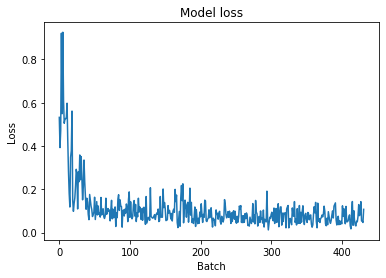

In [9]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.show()

C:\Users\Andrew Ramirez\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\Users\Andrew Ramirez\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\Users\Andrew Ramirez\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Total loss: 0.07 
Loss on secret: 0.07 
Loss on cover: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


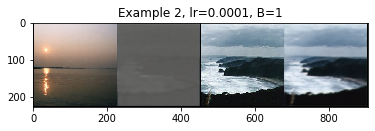

Total loss: 0.05 
Loss on secret: 0.04 
Loss on cover: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


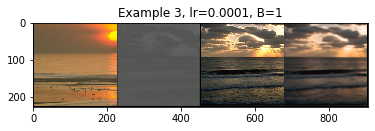

Total loss: 0.04 
Loss on secret: 0.04 
Loss on cover: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


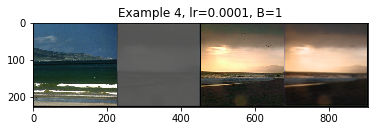

Total loss: 0.05 
Loss on secret: 0.05 
Loss on cover: 0.00


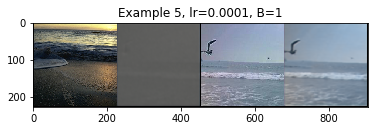

Average loss on test set: 0.08


In [14]:
# net.load_state_dict(torch.load(MODELS_PATH+'Epoch N4.pkl'))

# Switch to evaluate mode
net.eval()

test_losses = []
# Show images
for idx, test_batch in enumerate(test_loader):
     # Saves images
    data, _ = test_batch

    # Saves secret images and secret covers
    test_secret = data[:len(data)//2]
    test_cover = data[len(data)//2:]

    # Creates variable from secret and cover images
    test_secret = Variable(test_secret, volatile=True)
    test_cover = Variable(test_cover, volatile=True)

    # Compute output
    test_hidden, test_output = net(test_secret, test_cover)
    
    # Calculate loss
    test_loss, loss_cover, loss_secret = customized_loss(test_output, test_hidden, test_secret, test_cover, beta)
    
#     diff_S, diff_C = np.abs(np.array(test_output.data[0]) - np.array(test_secret.data[0])), np.abs(np.array(test_hidden.data[0]) - np.array(test_cover.data[0]))
    
#     print (diff_S, diff_C)
    
    if idx in [1,2,3,4]:
        print ('Total loss: {:.2f} \nLoss on secret: {:.2f} \nLoss on cover: {:.2f}'.format(test_loss.data, loss_secret.data, loss_cover.data))

        # Creates img tensor
        imgs = [test_secret.data, test_output.data, test_cover.data, test_hidden.data]
        imgs_tsor = torch.cat(imgs, 0)

        # Prints Images
        imshow(utils.make_grid(imgs_tsor), idx+1, learning_rate=learning_rate, beta=beta)
        
    test_losses.append(test_loss.data)
        
mean_test_loss = np.mean(test_losses)

print ('Average loss on test set: {:.2f}'.format(mean_test_loss))

### Testing with Kodak Set

C:\Users\Andrew Ramirez\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\Users\Andrew Ramirez\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\Users\Andrew Ramirez\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Total loss: 0.22 
Loss on secret: 0.22 
Loss on cover: 0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


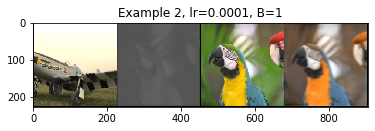

Total loss: 0.06 
Loss on secret: 0.05 
Loss on cover: 0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


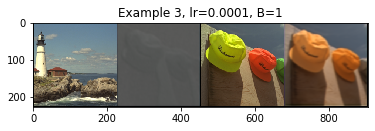

Total loss: 0.06 
Loss on secret: 0.05 
Loss on cover: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


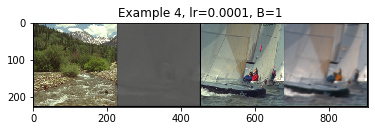

Total loss: 0.03 
Loss on secret: 0.03 
Loss on cover: 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


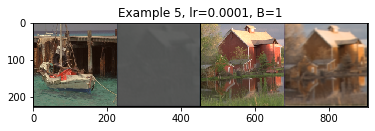

Average loss on test set: 0.07


In [21]:
# net.load_state_dict(torch.load(MODELS_PATH+'Epoch N4.pkl'))
kodak_path = 'kodakSet/temp'
kodak_test = torch.utils.data.DataLoader(
        datasets.ImageFolder(
        kodak_path, 
        transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize(mean=mean,
        #std=std)
        ])), batch_size=2, num_workers=1, 
        pin_memory=True, shuffle=True, drop_last=True)
# Switch to evaluate mode
net.eval()

test_losses = []
# Show images
for idx, test_batch in enumerate(kodak_test):
     # Saves images
    data, _ = test_batch

    # Saves secret images and secret covers
    test_secret = data[:len(data)//2]
    test_cover = data[len(data)//2:]

    # Creates variable from secret and cover images
    test_secret = Variable(test_secret, volatile=True)
    test_cover = Variable(test_cover, volatile=True)

    # Compute output
    test_hidden, test_output = net(test_secret, test_cover)
    
    # Calculate loss
    test_loss, loss_cover, loss_secret = customized_loss(test_output, test_hidden, test_secret, test_cover, beta)
    
#     diff_S, diff_C = np.abs(np.array(test_output.data[0]) - np.array(test_secret.data[0])), np.abs(np.array(test_hidden.data[0]) - np.array(test_cover.data[0]))
    
#     print (diff_S, diff_C)
    
    if idx in [1,2,3,4]:
        print ('Total loss: {:.2f} \nLoss on secret: {:.2f} \nLoss on cover: {:.2f}'.format(test_loss.data, loss_secret.data, loss_cover.data))

        # Creates img tensor
        imgs = [test_secret.data, test_output.data, test_cover.data, test_hidden.data]
        imgs_tsor = torch.cat(imgs, 0)

        # Prints Images
        imshow(utils.make_grid(imgs_tsor), idx+1, learning_rate=learning_rate, beta=beta)
        
    test_losses.append(test_loss.data)
        
mean_test_loss = np.mean(test_losses)

print ('Average loss on test set: {:.2f}'.format(mean_test_loss))